# AOS LSSTCam Full Array Mode Zernikes

Notebook Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: **6/4/2021** <br>
Verified Stack Release: **w_2021_20**

In [1]:
# Should match verified version above
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	current w_2021_20 setup


## Notebook Goal
Demonstrate the processing of wave front images for LSSTCam Full Array Mode (FAM) from raw to Zernikes.

## Installation

This notebook requires the LSST Science Pipelines as well as the following telescope and site packages: 
- `phosim_utils` (Only as a prerequisite for `ts_wep`. None of the code shown here uses it.) 
    - Tagged Version: `v0.2.7`
- `ts_wep`
    - Tagged Version: `v1.7.5`

### Installing `phosim_utils` and `ts_wep` on **Rubin Science Platform**

`phosim_utils` is available on GitHub [here](https://github.com/lsst-dm/phosim_utils) and `ts_wep` is available [here](https://github.com/lsst-ts/ts_wep). 

To install on **RSP** open a terminal in the notebook aspect: 
1. Set up the LSST Science Pipelines: 

```
source ${LOADSTACK}
setup lsst_distrib
```

2. Go to the directory you would like to install the packages and clone the `ts_phosim` and `ts_wep` repositories from the GitHub links above.
3. Inside the `phosim_utils` directory run the following to build the module:

```
setup -k -r .
scons
```

4. Repeat the same commands inside the `ts_wep` repository.
5. Add the following to your `${HOME}/notebooks/.user_setups` to run `ts_wep` in an **RSP** notebook:

```
setup -k -r {PATH_TO_PHOSIM_UTILS}
setup -k -r {PATH_TO_TS_WEP}
```
6. Restart notebook kernel and continue with the notebook.

## Data production

The phosim images used in this notebook were generated using `phosim_syseng4` with tag `v1.0.7`. They were repackaged using `phosim_utils` with tag `v0.2.7`. The command files and instance catalogs can be found in `/project/aos/phosim_output/lsstFamCam_2stars_25sensors_060421`.

## Run pipeline

### Pipeline Set Up

To run the full pipeline we can use the pipeline YAML file available for testing in `lsstFamCamPipeline.yaml` here in this directory. Here is what is in that file with comments:

In [2]:
! cat lsstFamCamPipeline.yaml

# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: Tr

### Run task from command line

Now we will run this pipeline using the `pipetask run` command available on the command line.

In [3]:
# Some basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This allows us to run command line tasks from inside the notebook easier
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, writeCleanUpRepoCmd

# Location of ts_wep
ts_wep_dir = os.environ['TS_WEP_DIR']

# Import Gen 3 Butler
from lsst.daf import butler as dafButler

#### Building our shell command

We need the following to specify our command:

In [4]:
# First specify the repository location
repoDir = '/project/aos/data_repos/lsstFamCam-w_2021_20/'
# Next we create a name for the output of our pipeline run
runName = 'famCam_test'
# We are going to use comcam data so we specify the correct instrument
instrument = 'lsst.obs.lsst.LsstCam'
# Tell the pipeline which existing data in the repository to use
collections = 'refcats,LSSTCam/raw/all,LSSTCam/calib'
# And finally the file that specifies our pipeline tasks and configurations shown above
pipelineYaml = 'lsstCamPipeline.yaml'

Let's take a brief look inside our data repository by looking at the `butler.registry`

In [5]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

In [6]:
# What exposures are ingested already?
for dataId in registry.queryDataIds('exposure'):
    print(dataId)

{instrument: 'LSSTCam', exposure: 4021123106001, ...}
{instrument: 'LSSTCam', exposure: 4021123106003, ...}
{instrument: 'LSSTCam', exposure: 4021123106000, ...}
{instrument: 'LSSTCam', exposure: 4021123106002, ...}
{instrument: 'LSSTCam', exposure: 4021123106004, ...}


We see that there are a number of `LSSTCam` exposures available. We only want the extra-focal and intra-focal exposures; `4021123106001` and `4021123106003`, respectively. So we will specify those when building our command below
with the help from the function `writePipetaskCmd` available in `ts_wep`.

In [7]:
# Use the utility function in ts_wep to write our pipeline task command
runPipeTaskCmd = writePipetaskCmd(repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml)

In [8]:
# Add command to grab the specific extra-focal and intra-focal exposures we want to use
runPipeTaskCmd += ' -d "exposure IN (4021123106001, 4021123106003)"'

In [9]:
# # Add number of processors to use in parallel
runPipeTaskCmd += ' -j 2'

What does the full command look like?

In [10]:
print(runPipeTaskCmd)

pipetask run -b /project/aos/data_repos/lsstFamCam-w_2021_20/ -i refcats,LSSTCam/raw/all,LSSTCam/calib --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run famCam_test -p lsstCamPipeline.yaml -d "exposure IN (4021123106001, 4021123106003)" -j 2


In [ ]:
# Run pipetask (This takes about 3 minutes on `lsst-devl02` with `-j 25`).
%time ! {runPipeTaskCmd}

## Exploring Output

After our task runs we can now look at the new output saved in our data repository and accessible by the `butler`.

First, we need reload the butler to get the updated registry.

In [11]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

We can run `queryCollections` to see the available datasets and see that there is now a dataset called `famCam_test` available.

In [12]:
for x in registry.queryCollections():
    print(x)

LSSTCam/raw/all
LSSTCam/calib
LSSTCam/calib/unbounded
refcats/gen2
refcats
LSSTCam/defaults
skymaps
famCam_test


We can also look inside the registry to see the available dataset types. We have added `donutCatalog`, `donutStampsExtra`, `donutStampsIntra`, `zernikeEstimateRaw` and `zernikeEstimateAvg`.

In [13]:
dataTypes = registry.queryDatasetTypes()
for dataType in dataTypes:
    print(dataType)

DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cal_ref_cat', {htm7}, SimpleCatalog)
DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('donutCatalog', {instrument}, DataFrame)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('donutStampsIntra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('zernikeEstimateRaw', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('zernikeEstimateAvg', {band, instrument, detector, physical_filter, exposure}, NumpyArray)
DatasetType('donutStampsExtra', {band, instrument, detector, physical_filter, exposure}, StampsBase)
DatasetType('estimateZernikesFamTask_metadata', {instrument, detector}, PropertySet)
DatasetType('generateDonutCatalogOnlineTask_metadata', {instrum

To start exploring the new data products let's pick a `dataId` from inside `famCam_test` with an available `postISRCCD`.

In [14]:
datasetRefs = list(registry.queryDatasets(datasetType='postISRCCD', collections=[runName]))
for ref in datasetRefs:
    print(ref.dataId)

{instrument: 'LSSTCam', detector: 19, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 76, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 130, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 1, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 175, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 31, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 187, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 13, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 184, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 58, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 157, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 103, exposure: 4021123106003, ...}
{instrument: 'LSSTCam', detector: 121, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 1, exposure: 4021123106001, ...}
{instrument: 'LSSTCam', detector: 175, expo

In [15]:
dataId = {'instrument': 'LSSTCam', 'detector': 85, 'exposure': 4021123106001}

### Load a postISR image

In [16]:
postIsrExp = butler.get('postISRCCD', dataId=dataId, collections=[runName])

Text(0.5, 1.0, 'Donut Sources on R21_S11')

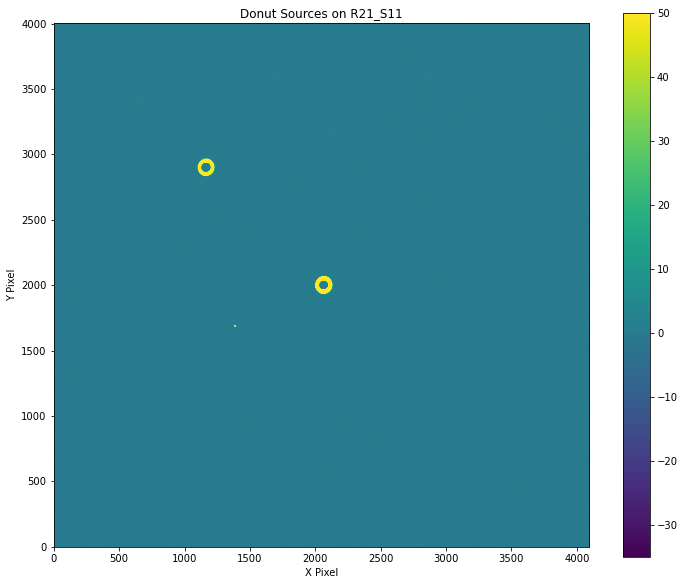

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(12, 10))
plt.imshow(postIsrExp.image.array, origin='lower', vmax=50)
plt.colorbar()
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title(f'Donut Sources on {postIsrExp.getDetector().getName()}')

Let's plot this with ra, dec coordinates. To do this we define the following function to make it easy.

In [18]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import astropy.units as u

def plotRaDec(postIsrExp):
    
    """
    Plot the image data and the WCS overlay.
    
    Parameters
    ----------
    postIsrExp : lsst.afw.image.Exposure
        The post-ISR exposure from the butler repository.
    """
    # Get the WCS for the projection
    wcs = postIsrExp.getWcs()
    header_dict = dict(wcs.getFitsMetadata())
    
    # Add in axis information
    header_dict['NAXIS'] = 2
    header_dict['NAXIS1'] = 4072
    header_dict['NAXIS2'] = 4000
    
    # Convert to astropy readable WCS
    astropyWcs = WCS(header_dict)
    
    # Grab image data and plot
    data = postIsrExp.getImage().getArray()
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    plt.subplot(projection=astropyWcs)#, slices=('y', 'x'))
    plt.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys',)

    # Format coordinates presentation
    ax = plt.gca()

    ax.coords[0].grid(color='yellow')
    ax.set_xlabel('RA')
    
    ax.coords[1].grid(color='yellow')
    ax.set_ylabel('Dec')

Text(0.5, 1.0, 'Donut Sources on R21_S11')

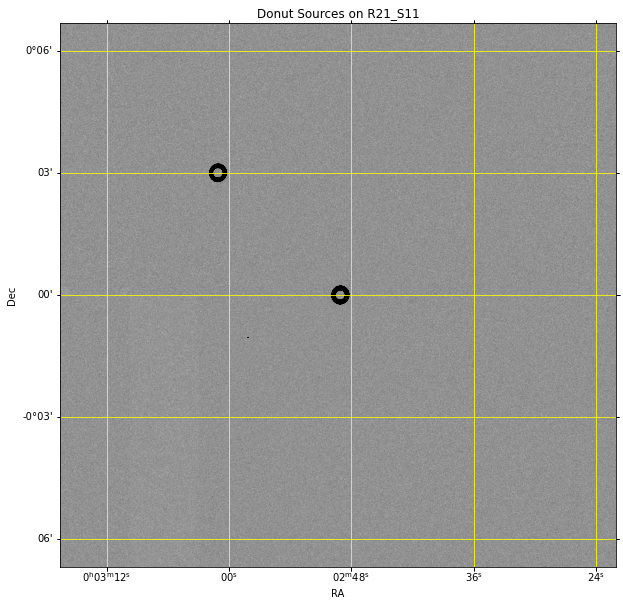

In [19]:
# plot the data and the WCS overlay 
fig = plt.figure(figsize=(10,10))
plotRaDec(postIsrExp)
plt.title(f'Donut Sources on {postIsrExp.getDetector().getName()}')

### Load the donut catalog for an exposure

In [20]:
srcCat = butler.get('donutCatalog', dataId=dataId, collections=[runName])

In [21]:
srcCat

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,detector
0,0.012314,-0.028725,2035.850012,1990.108132,3.630781e+06,R01_S01
1,0.013187,-0.027853,1135.703619,2890.577357,1.445440e+06,R01_S01
2,0.012314,-0.024629,2035.850012,1993.438817,3.630781e+06,R01_S11
3,0.013187,-0.023756,1135.703619,2893.761399,1.445440e+06,R01_S11
4,0.000000,-0.024629,2036.500000,1995.365173,3.630781e+06,R02_S11
5,0.000873,-0.023756,1136.499772,2895.882842,1.445440e+06,R02_S11
6,6.270871,-0.028725,2037.149988,1990.108132,3.630781e+06,R03_S01
7,6.271744,-0.027853,1137.022942,2891.194966,1.445440e+06,R03_S01
8,6.270871,-0.024629,2037.149988,1993.438817,3.630781e+06,R03_S11
9,6.271744,-0.023756,1137.022942,2894.288130,1.445440e+06,R03_S11


Let's make sure our `donutCatalog` is correct.

In [22]:
exposureName = postIsrExp.getDetector().getName()

In [23]:
expCatalog = srcCat.query(f'detector == "{exposureName}"')

Text(0.5, 1.0, 'Donut Sources on R21_S11')

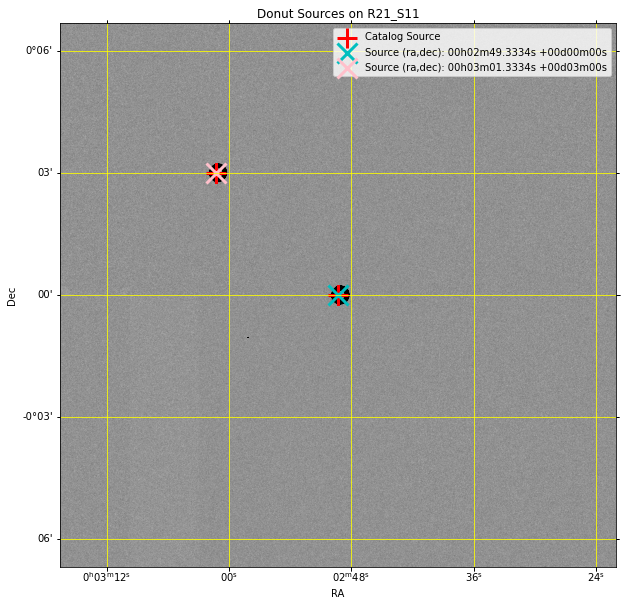

In [24]:
from astropy.coordinates import SkyCoord

fig = plt.figure(figsize=(24, 10))
plotRaDec(postIsrExp)
plt.scatter(expCatalog['centroid_x'], expCatalog['centroid_y'], c='r', s=400, marker='+', lw=3, label='Catalog Source')
source_0 = SkyCoord(ra=expCatalog['coord_ra'].iloc[0] * u.rad, dec=expCatalog['coord_dec'].iloc[0] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[0], expCatalog['centroid_y'].iloc[0], marker='x', s=400, c='c', lw=3, 
            label=f"Source (ra,dec): {source_0.to_string('hmsdms')}")
source_1 = SkyCoord(ra=expCatalog['coord_ra'].iloc[1] * u.rad, dec=expCatalog['coord_dec'].iloc[1] * u.rad, frame='icrs')
plt.scatter(expCatalog['centroid_x'].iloc[1], expCatalog['centroid_y'].iloc[1], marker='x', s=400, c='pink', lw=3, 
            label=f"Source (ra,dec): {source_1.to_string('hmsdms')}")
plt.legend()
plt.title(f'Donut Sources on {postIsrExp.getDetector().getName()}')

Looks good. Our catalog sources lie on top of the donuts and our two sample coordinates match up the coordinates we expect to see on the image.

### Look at the `donutStamps`

In [25]:
extraFocalStamps = butler.get('donutStampsExtra', dataId=dataId, collections=[runName])

The `donutStamps` objects contain the postage stamps as `lsst.afw.image.MaskedImage` objects along with extra metadata. Here we will load the image from one of the objects.

Text(0, 0.5, 'Y Pixel')

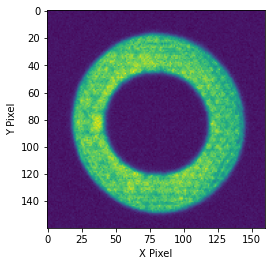

In [26]:
plt.imshow(extraFocalStamps[0].stamp_im.image.getArray())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')

### Load the Zernike coefficients and compare to OPD

In [27]:
zerCoeff = butler.get('zernikeEstimateAvg', dataId=dataId, collections=[runName])

In [28]:
zerCoeff

array([-6.23157102e-01,  8.65084736e-01,  9.25508080e-01, -5.26998403e-02,
        1.47242326e-02,  7.03851090e-02, -2.10898892e-02,  9.20230317e-03,
       -3.47687641e-02, -3.87778866e-02,  3.50360339e-02,  3.66810398e-02,
       -6.23892037e-03, -1.75921494e-03, -1.00187662e-02,  1.06832198e-02,
        3.22364229e-06,  2.18887328e-02, -1.02017957e-02])

In [29]:
opdVals = np.genfromtxt('/project/aos/phosim_output/lsstFamCam_2stars_25sensors_060421/opd.zer')

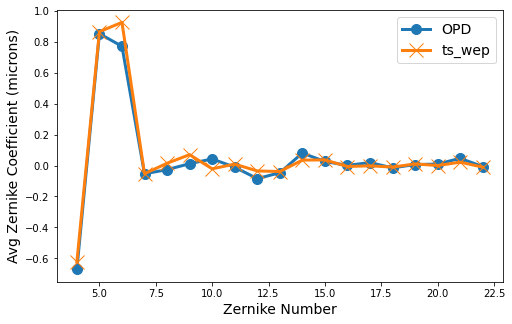

In [30]:
fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(4, 23), opdVals[85], '-o', lw=3, markersize=10, label='OPD')
plt.plot(np.arange(4, 23), zerCoeff, '-x', lw=3, markersize=14, label='ts_wep')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Avg Zernike Coefficient (microns)', size=14)
plt.legend(fontsize=14)

## Running pipeline tasks in-memory

When running these tasks it might be useful to speed things up by running the tasks without the I/O involved writing and getting data from the repository. Here we show how to run the tasks completely in memory.

### Create the donut catalog

First we still need to create a donut catalog that contains the information on sources in our pointing.

In [32]:
from lsst.ts.wep.task.GenerateDonutCatalogOnlineTask import GenerateDonutCatalogOnlineTask, GenerateDonutCatalogOnlineTaskConfig

#### Set configurations for the task

To set our configurations we will get boresight pointing information from the raw image as an example.

In [33]:
rawImage = butler.get('raw', dataId=dataId, collections=['LSSTCam/raw/all'])

In [34]:
rawImVisitInfo = rawImage.getInfo().getVisitInfo()
print(f"Boresight Ra, Dec is: {rawImVisitInfo.getBoresightRaDec()}, Boresight Rotation Angle in degrees is: {rawImVisitInfo.getBoresightRotAngle().asDegrees()}")

Boresight Ra, Dec is: (0.0000000000, +0.0000000000), Boresight Rotation Angle in degrees is: 0.0


We can now set up our configurations for our task.

In [35]:
donutCatConfig = GenerateDonutCatalogOnlineTaskConfig()
donutCatConfig.boresightRa = rawImVisitInfo.getBoresightRaDec().getRa().asDegrees()
donutCatConfig.boresightDec = rawImVisitInfo.getBoresightRaDec().getDec().asDegrees()
donutCatConfig.boresightRotAng = rawImVisitInfo.getBoresightRotAngle().asDegrees()

Then we feed this configuration information as we instantiate our task.

In [36]:
donutCatTask = GenerateDonutCatalogOnlineTask(config=donutCatConfig)

#### Prepare the data for the task

For our task we need to get the reference catalog available in the `Butler` repository. To do that we create a set of deferred pointers to the data so that they will only load into memory when we need them.

In [37]:
deferredList = []
datasetGenerator = registry.queryDatasets(datasetType="cal_ref_cat", collections=["refcats"]).expanded()
for ref in datasetGenerator:
    deferredList.append(butler.getDeferred(ref, collections=["refcats"]))

The final piece of data we need to specify is the camera we used in the pointing.

In [38]:
camera = "LSSTCam"

#### Run the task

In [39]:
donutCatStruct = donutCatTask.run(camera, deferredList)

The task returns a `Struct` object.

In [40]:
donutCatStruct

Struct(donutCatalog=    coord_ra  coord_dec   centroid_x   centroid_y   source_flux detector
0   0.012314  -0.028725  2035.850012  1990.108132  3.630781e+06  R01_S01
1   0.013187  -0.027853  1135.703619  2890.577357  1.445440e+06  R01_S01
2   0.012314  -0.024629  2035.850012  1993.438817  3.630781e+06  R01_S11
3   0.013187  -0.023756  1135.703619  2893.761399  1.445440e+06  R01_S11
4   0.000873  -0.023756  1136.499772  2895.882842  1.445440e+06  R02_S11
5   0.000000  -0.024629  2036.500000  1995.365173  3.630781e+06  R02_S11
6   6.270871  -0.028725  2037.149988  1990.108132  3.630781e+06  R03_S01
7   6.271744  -0.027853  1137.022942  2891.194966  1.445440e+06  R03_S01
8   6.270871  -0.024629  2037.149988  1993.438817  3.630781e+06  R03_S11
9   6.271744  -0.023756  1137.022942  2894.288130  1.445440e+06  R03_S11
10  0.025501  -0.011442  1130.799457  2896.139013  1.445440e+06  R10_S11
11  0.024629  -0.012314  2031.365173  1995.997156  3.630781e+06  R10_S11
12  0.013187  -0.011442  1146.7

We can get the `donutCatalog` out of it by specifying the property `donutCatalog`.

In [41]:
donutCatalog = donutCatStruct.donutCatalog

In [42]:
donutCatalog.head()

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,detector
0,0.012314,-0.028725,2035.850012,1990.108132,3.630781e+06,R01_S01
1,0.013187,-0.027853,1135.703619,2890.577357,1.445440e+06,R01_S01
2,0.012314,-0.024629,2035.850012,1993.438817,3.630781e+06,R01_S11
3,0.013187,-0.023756,1135.703619,2893.761399,1.445440e+06,R01_S11
4,0.000873,-0.023756,1136.499772,2895.882842,1.445440e+06,R02_S11


### Running the Zernike Estimation

Now we can run the same steps to get the Zernike coefficients back in memory.

In [43]:
from lsst.ts.wep.task.EstimateZernikesFamTask import EstimateZernikesFamTask, EstimateZernikesFamTaskConfig

#### Configure Task

Here we can use the defaults so we just instatiate the configuration class.

In [44]:
estimateZernikeConfig = EstimateZernikesFamTaskConfig()
estimateZernikeTask = EstimateZernikesFamTask(config=estimateZernikeConfig)

#### Prepare data for task

Here we will assume the ISR was done somewhere else and just take the postISR images from our `notebook_test` run earlier.

In [45]:
expExtra = butler.get('postISRCCD', dataId={'instrument': 'LSSTCam', 'detector': 85, 'exposure': 4021123106001}, collections=['famCam_test'])

In [46]:
expIntra = butler.get('postISRCCD', dataId={'instrument': 'LSSTCam', 'detector': 85, 'exposure': 4021123106003}, collections=['famCam_test'])

In [47]:
expPair = [expExtra, expIntra]

#### Run Task

In [48]:
# This will take around a minute on medium instance on RSP
zernikeOutput = estimateZernikeTask.run(expPair, donutCatalog)

This returns a `Struct` once again but with multiple data products returned.

In [49]:
zernikeOutput

Struct(outputZernikesAvg=[-6.23157102e-01  8.65084736e-01  9.25508080e-01 -5.26998403e-02
  1.47242326e-02  7.03851090e-02 -2.10898892e-02  9.20230317e-03
 -3.47687641e-02 -3.87778866e-02  3.50360339e-02  3.66810398e-02
 -6.23892037e-03 -1.75921494e-03 -1.00187662e-02  1.06832198e-02
  3.22364229e-06  2.18887328e-02 -1.02017957e-02]; outputZernikesRaw=[[-6.30314597e-01  8.76390339e-01  8.73199116e-01 -4.94244368e-02
   1.56510228e-02  7.07057811e-02  1.63473975e-02  1.11317728e-02
  -2.58075407e-02 -4.01820983e-02  3.76124204e-02  3.66476739e-02
  -6.70391122e-03  2.33519249e-04 -1.47909518e-02  1.21668988e-02
  -6.19890504e-03  1.72977819e-02 -1.01743565e-02]
 [-6.15999606e-01  8.53779133e-01  9.77817044e-01 -5.59752438e-02
   1.37974425e-02  7.00644368e-02 -5.85271758e-02  7.27283357e-03
  -4.37299875e-02 -3.73736750e-02  3.24596475e-02  3.67144057e-02
  -5.77392953e-03 -3.75194914e-03 -5.24658065e-03  9.19954083e-03
   6.20535232e-03  2.64796836e-02 -1.02292349e-02]]; donutStampsExt

To get our coefficients we can once again just use the property we want.

In [50]:
zernikeOutput.outputZernikesAvg

array([-6.23157102e-01,  8.65084736e-01,  9.25508080e-01, -5.26998403e-02,
        1.47242326e-02,  7.03851090e-02, -2.10898892e-02,  9.20230317e-03,
       -3.47687641e-02, -3.87778866e-02,  3.50360339e-02,  3.66810398e-02,
       -6.23892037e-03, -1.75921494e-03, -1.00187662e-02,  1.06832198e-02,
        3.22364229e-06,  2.18887328e-02, -1.02017957e-02])

## (Optional) Clean up run

If after running through this notebook you wish to restore the repository to the original state before the start of the pipeline run you can run the following command which will remove the data from the `notebook_test` run.

In [51]:
cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)

In [52]:
print(cleanUpCmd)

butler prune-collection /project/aos/data_repos/lsstFamCam-w_2021_20/ famCam_test --purge --unstore


In [14]:
# Uncomment below to run repository clean up and remove data from this notebook.
# ! {cleanUpCmd}